# Tensorflow network 2

## Starting with getting and preparing the data

In [150]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from tensorflow.keras.regularizers import l2

In [151]:
dev_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_data.pkl")
test_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"test_data.pkl")
training_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"training_data.pkl")
training_data.shape

(254696, 446)

In [152]:
dev_data.columns.get_level_values(0).unique()

Index(['Player Status', 'Inning Data', 'Batting Stats', 'Bowling Stats',
       'Ground Data', 'Final Output'],
      dtype='object')

In [153]:
training_data['Ground Data']

-                          \
                          The Rose Bowl Eden Park County Ground   
        Country Over Ball                                         
1237122 England 0    0              0.0       0.0           0.0   
                     1              0.0       0.0           0.0   
                     2              0.0       0.0           0.0   
                     3              0.0       0.0           0.0   
                     4              0.0       0.0           0.0   
...                                 ...       ...           ...   
1336955 Japan   17   5              0.0       0.0           0.0   
                18   0              0.0       0.0           0.0   
                     1              0.0       0.0           0.0   
                     2              0.0       0.0           0.0   
                     3              0.0       0.0           0.0   

                                                                  \
                          Brisbane Cricket Ground, Woolloongabba   
        Country Over Ball                                          
1237122 England 0    0                                       0.0   
                     1                                       0.0   
                     2                                       0.0   
                     3                                       0.0   
                     4                                       0.0   
...                                                          ...   
1336955 Japan   17   5                                       0.0   
                18   0                                       0.0   
                     1                                       0.0   
                     2                                       0.0   
                     3                                       0.0   

                                                                       \
                          New Wanderers Stadium Sydney Cricket Ground   
        Country Over Ball                                               
1237122 England 0    0                      0.0                   0.0   
                     1                      0.0                   0.0   
                     2                      0.0                   0.0   
                     3                      0.0                   0.0   
                     4                      0.0                   0.0   
...                                         ...                   ...   
1336955 Japan   17   5                      0.0                   0.0   
                18   0                      0.0                   0.0   
                     1                      0.0                   0.0   
                     2                      0.0                   0.0   
                     3                      0.0                   0.0   

                                                                              \
                          Westpac Stadium Kennington Oval Kingsmead Newlands   
        Country Over Ball                                                      
1237122 England 0    0                0.0             0.0       0.0      1.0   
                     1                0.0             0.0       0.0      1.0   
                     2                0.0             0.0       0.0      1.0   
                     3                0.0             0.0       0.0      1.0   
                     4                0.0             0.0       0.0      1.0   
...                                   ...             ...       ...      ...   
1336955 Japan   17   5                0.0             0.0       0.0      0.0   
                18   0                0.0             0.0       0.0      0.0   
                     1                0.0             0.0       0.0      0.0   
                     2                0.0             0.0       0.0      0.0   
                     3                0.0             0.0       0.0      0.0   

  

In [154]:
training_x_inning = training_data['Inning Data'].reset_index(['Over', 'Ball'])
training_x_ground = training_data['Ground Data']
training_y = training_data['Final Output']

dev_data_x = dev_data['Inning Data'].reset_index(['Over', 'Ball'])
dev_x_ground = dev_data['Ground Data']
dev_data_y = dev_data['Final Output']

print(training_x_inning.shape)
print(training_x_ground.shape)
print(training_y.shape)
print()
print(dev_data_x.shape)
print(dev_x_ground.shape)
print(dev_data_y.shape)

(254696, 4)
(254696, 245)
(254696, 1)

(23552, 4)
(23552, 245)
(23552, 1)


In [155]:
train_x_inn = tf.convert_to_tensor(training_x_inning)
train_x_gr = tf.convert_to_tensor(training_x_ground)
train_y = tf.convert_to_tensor(training_y)

dev_x_inn = tf.convert_to_tensor(dev_data_x)
dev_x_gr = tf.convert_to_tensor(dev_x_ground)
dev_y = tf.convert_to_tensor(dev_data_y)

print(train_y.shape)
print(dev_y.shape)

(254696, 1)
(23552, 1)


## Declaring some important functions

In [156]:
# This class defines the accuracy

class CountAroundRange(tf.keras.metrics.Metric):
    def __init__(self, range_tolerance, name='count_around_range', **kwargs):
        super(CountAroundRange, self).__init__(name=name, **kwargs)
        self.range_tolerance = range_tolerance
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
        self.true_within_range = self.add_weight(name='true_within_range', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        in_range = tf.math.abs(y_true - y_pred) <= self.range_tolerance
        in_range = tf.cast(in_range, tf.float32)

        self.total_samples.assign_add(tf.cast(tf.shape(in_range)[0], tf.float32))
        self.true_within_range.assign_add(tf.reduce_sum(in_range))

    def result(self):
        return self.true_within_range / self.total_samples
    
count_20 = CountAroundRange(range_tolerance = 20, name = 'Count_20')
count_10 = CountAroundRange(range_tolerance = 10, name = 'Count_10')

## Time to train the models

## The first model

**Architecture**

- 4 (input) -> 8 -> dropout -> 5 -> 1 (output) 
- Using Relu Activations
- Kernel Regularizer used for dense layers -- L2 with 0.01 lambda value

- Loss is Mean Squared Error

In [36]:
model = tf.keras.Sequential([
    tfl.Input(shape = (4,)),
    #tfl.Dense(units = 100, activation = 'relu', kernel_regularizer=l2(0.01)),
    # tfl.Dense(units = 50, activation = 'relu', kernel_regularizer=l2(0.01)),
    #tfl.Dense(units = 20, activation = 'relu', kernel_regularizer=l2(0.01)),
    tfl.Dense(units = 8, activation = 'relu', kernel_regularizer=l2(0.01)),
    tfl.Dropout(0.2),
    tfl.Dense(units = 5, activation = 'relu', kernel_regularizer=l2(0.01)),
    tfl.Dense(units = 1, activation = 'linear')
])

In [48]:
model.compile(optimizer = 'adam', loss = 'MeanSquaredError', metrics = [count_20, count_10])

In [49]:
num_epochs = 5
batch_size = 64

history = model.fit(train_x_inn, train_y, epochs = num_epochs, batch_size =batch_size, validation_data = (dev_x_inn, dev_y))

Epoch 1/5
3980/3980 [==============================] - 2s 587us/step - loss: 765.6829 - Count_20: 0.6059 - Count_10: 0.3570 - val_loss: 667.7521 - val_Count_20: 0.6464 - val_Count_10: 0.3795
Epoch 2/5
3980/3980 [==============================] - 2s 498us/step - loss: 765.0986 - Count_20: 0.6047 - Count_10: 0.3555 - val_loss: 698.9648 - val_Count_20: 0.6279 - val_Count_10: 0.3632
Epoch 3/5
3980/3980 [==============================] - 2s 497us/step - loss: 766.0308 - Count_20: 0.6046 - Count_10: 0.3548 - val_loss: 683.5543 - val_Count_20: 0.6368 - val_Count_10: 0.3723
Epoch 4/5
3980/3980 [==============================] - 2s 493us/step - loss: 766.4202 - Count_20: 0.6046 - Count_10: 0.3551 - val_loss: 687.8390 - val_Count_20: 0.6328 - val_Count_10: 0.3689
Epoch 5/5
3980/3980 [==============================] - 2s 527us/step - loss: 766.3234 - Count_20: 0.6045 - Count_10: 0.3553 - val_loss: 682.4594 - val_Count_20: 0.6351 - val_Count_10: 0.3722


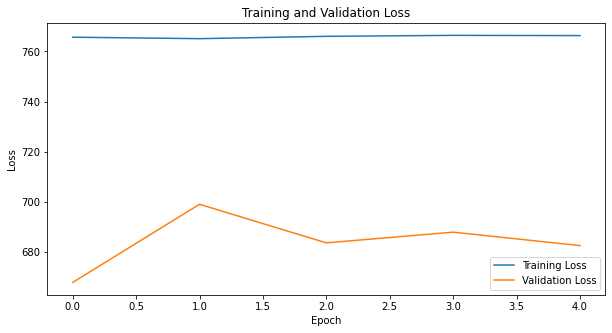

In [50]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
dev_loss, dev_accuracy_20, dev_accuracy_10 = model.evaluate(dev_x_inn, dev_y)

print(dev_loss)
print(dev_accuracy)
print ("---------")
train_loss, train_accuracy_20, train_accuracy_10 = model.evaluate(train_x_inn, train_y)
print(train_loss)
print(train_accuracy)

736/736 [==============================] - 0s 653us/step - loss: 682.4596 - Count_20: 0.6351 - Count_10: 0.3722
682.4595947265625
0.6232166886329651
---------
7960/7960 [==============================] - 5s 655us/step - loss: 768.0696 - Count_20: 0.6001 - Count_10: 0.3511
768.069580078125
0.5967702865600586


In [52]:
for thres_overs in [0, 5, 10, 15, 19]:
    # Make a mask to get the relevant data
    mask = (dev_data_x['Over'] >= thres_overs).to_numpy()
    
    prediction_x = tf.convert_to_tensor(dev_x_inn[mask])
    prediction_y = tf.convert_to_tensor(dev_y[mask])
    print(prediction_x.shape)
    print(prediction_y.shape)
    
    ## Get the predictions
    prediction_loss, prediction_accuracy_20, prediction_accuracy_10 = model.evaluate(prediction_x, prediction_y)
    print(f"Over Range last {20 - thres_overs} overs --------------------------")
    print(f"Accuracy within 20 runs: {prediction_accuracy_20}    Accuracy Within 10 runs: {prediction_accuracy_10}")

(23552, 4)
(23552, 1)
736/736 [==============================] - 0s 644us/step - loss: 682.4596 - Count_20: 0.6351 - Count_10: 0.3722
Over Range last 20 overs --------------------------
Accuracy within 20 runs: 0.6350628137588501    Accuracy Within 10 runs: 0.37215521931648254
(17213, 4)
(17213, 1)
538/538 [==============================] - 0s 677us/step - loss: 487.8527 - Count_20: 0.6959 - Count_10: 0.4151
Over Range last 15 overs --------------------------
Accuracy within 20 runs: 0.6959275007247925    Accuracy Within 10 runs: 0.41509324312210083
(11041, 4)
(11041, 1)
346/346 [==============================] - 0s 685us/step - loss: 322.9395 - Count_20: 0.7767 - Count_10: 0.4839
Over Range last 10 overs --------------------------
Accuracy within 20 runs: 0.7766506671905518    Accuracy Within 10 runs: 0.4839235544204712
(5036, 4)
(5036, 1)
158/158 [==============================] - 0s 698us/step - loss: 160.7354 - Count_20: 0.9007 - Count_10: 0.6148
Over Range last 5 overs -----------

## Summary

**This Models Output is as follows**

|Threshold | Accuracy within 20 runs | Accuracy within 10 runs | MSE |
| --- | --- | --- | --- |
| None | 63% | 37 % | 682 |
| >5 Overs | 70% | 42% | 488 |
| > 10 Overs | 78% | 48% | 322 |
| > 15 Overs | 90% | 61 % | 161 |
| Last Over | 99% | 85% | 55 |

## The Second Model

- We will use functional API now
- We will also be adding the ground data here

Here is the Data we are using:

In [56]:
print(train_x_inn.shape)
print(train_x_gr.shape)
print(train_y.shape)

(254696, 4)
(254696, 245)
(254696, 1)


In [84]:
## Making the model no 2

input_inn = tfl.Input(shape = (4,))
branch_inn = tfl.Dense(8, activation = 'relu', kernel_regularizer = l2(0.02))(input_inn)
branch_inn = tfl.Dropout(0.2)(branch_inn)
branch_inn = tfl.Dense(4, activation = 'relu', kernel_regularizer = l2(0.02))(branch_inn)

input_gr = tfl.Input(shape = (245,))
branch_gr = tfl.Dense(100, activation = 'relu', kernel_regularizer = l2(0.02))(input_gr)
branch_gr = tfl.Dropout(0.2)(branch_gr)
branch_gr = tfl.Dense(10, activation = 'relu', kernel_regularizer = l2(0.02))(branch_gr)
branch_gr = tfl.Dropout(0.2)(branch_gr)
branch_gr = tfl.Dense(2, activation = 'relu', kernel_regularizer = l2(0.02))(branch_gr)

merged = tfl.concatenate([branch_inn, branch_gr])

merged = tfl.Dropout(0.2)(merged)
merged = tfl.Dense(5, activation = 'relu')(merged)
output = tfl.Dense(1, activation = 'linear')(merged)

## Defining the model here

model_2 = tf.keras.models.Model(inputs = [input_inn, input_gr], outputs = output)

# Compile the model
model_2.compile(optimizer = 'adam', loss = 'MeanSquaredError', metrics = [count_20, count_10])
model_2.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 245)]        0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 100)          24600       input_18[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 100)          0           dense_45[0][0]                   
_______________________________________________________________________________________

In [91]:
num_epochs = 20
batch_size = 64

history = model_2.fit([train_x_inn, train_x_gr], train_y, epochs = num_epochs, batch_size =batch_size, validation_data = ([dev_x_inn, dev_x_gr], dev_y))

Epoch 1/20
3980/3980 [==============================] - 4s 1ms/step - loss: 847.1355 - Count_20: 0.5724 - Count_10: 0.3224 - val_loss: 678.1651 - val_Count_20: 0.6349 - val_Count_10: 0.3820
Epoch 2/20
3980/3980 [==============================] - 4s 1ms/step - loss: 841.7390 - Count_20: 0.5739 - Count_10: 0.3230 - val_loss: 685.2495 - val_Count_20: 0.6286 - val_Count_10: 0.3760
Epoch 3/20
3980/3980 [==============================] - 4s 1ms/step - loss: 840.2078 - Count_20: 0.5746 - Count_10: 0.3247 - val_loss: 679.7315 - val_Count_20: 0.6346 - val_Count_10: 0.3822
Epoch 4/20
3980/3980 [==============================] - 4s 1ms/step - loss: 839.3279 - Count_20: 0.5733 - Count_10: 0.3235 - val_loss: 685.5128 - val_Count_20: 0.6329 - val_Count_10: 0.3805
Epoch 5/20
3980/3980 [==============================] - 4s 1ms/step - loss: 836.9167 - Count_20: 0.5737 - Count_10: 0.3238 - val_loss: 681.5649 - val_Count_20: 0.6318 - val_Count_10: 0.3832
Epoch 6/20
3980/3980 [============================

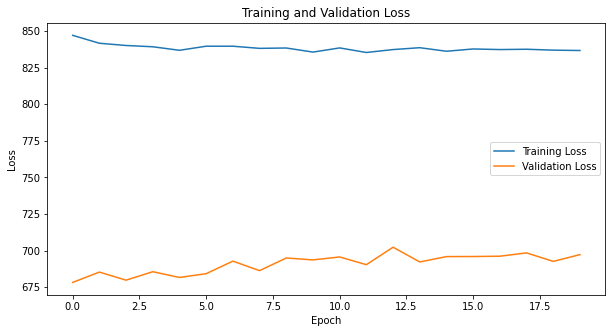

In [92]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
dev_loss, dev_accuracy_20, dev_accuracy_10 = model_2.evaluate([dev_x_inn, dev_x_gr], dev_y)

print(dev_loss)
print(dev_accuracy_20)
print ("---------")
train_loss, train_accuracy_20, train_accuracy_10 = model_2.evaluate([train_x_inn, train_x_gr], train_y)
print(train_loss)
print(train_accuracy_20)

736/736 [==============================] - 1s 854us/step - loss: 697.1826 - Count_20: 0.6285 - Count_10: 0.3729
697.1826171875
0.628524124622345
---------
7960/7960 [==============================] - 7s 836us/step - loss: 773.4013 - Count_20: 0.5971 - Count_10: 0.3508
773.4013061523438
0.5970686674118042


In [88]:
for thres_overs in [0, 5, 10, 15, 19]:
    # Make a mask to get the relevant data
    mask = (dev_data_x['Over'] >= thres_overs).to_numpy()
    
    prediction_x = [tf.convert_to_tensor(dev_x_inn[mask]), tf.convert_to_tensor(dev_x_gr[mask])]
    prediction_y = tf.convert_to_tensor(dev_y[mask])
    #print(prediction_x.shape)
    print(prediction_y.shape)
    
    ## Get the predictions
    prediction_loss, prediction_accuracy_20, prediction_accuracy_10 = model_2.evaluate(prediction_x, prediction_y)
    print(f"Over Range last {20 - thres_overs} overs --------------------------")
    print(f"Accuracy within 20 runs: {prediction_accuracy_20}    Accuracy Within 10 runs: {prediction_accuracy_10}")

(23552, 1)
736/736 [==============================] - 1s 845us/step - loss: 674.9269 - Count_20: 0.6389 - Count_10: 0.3845
Over Range last 20 overs --------------------------
Accuracy within 20 runs: 0.6388841867446899    Accuracy Within 10 runs: 0.38451087474823
(17213, 1)
538/538 [==============================] - 0s 854us/step - loss: 486.4250 - Count_20: 0.7001 - Count_10: 0.4247
Over Range last 15 overs --------------------------
Accuracy within 20 runs: 0.7000522613525391    Accuracy Within 10 runs: 0.4246790111064911
(11041, 1)
346/346 [==============================] - 0s 836us/step - loss: 327.2386 - Count_20: 0.7764 - Count_10: 0.4895
Over Range last 10 overs --------------------------
Accuracy within 20 runs: 0.7763789296150208    Accuracy Within 10 runs: 0.4895389974117279
(5036, 1)
158/158 [==============================] - 0s 846us/step - loss: 163.6866 - Count_20: 0.8952 - Count_10: 0.6237
Over Range last 5 overs --------------------------
Accuracy within 20 runs: 0.8951

## The Third Model

We will be adding player data in this model now

In [157]:
batting_status = training_data['Player Status']['Batting Team']
bowling_status = training_data['Player Status']['Bowling Team']
batting_status_dev = dev_data['Player Status']['Batting Team']
bowling_status_dev = dev_data['Player Status']['Bowling Team']

**We will be selecting Average and SR from this data**

In [158]:
batting_stats = training_data['Batting Stats'].loc[:, (slice(None), ['Ave', 'SR'])]
batting_stats_dev = dev_data['Batting Stats'].loc[:, (slice(None), ['Ave', 'SR'])]

**We will be selecting Economy and Ave from here**

In [159]:
bowling_stats = training_data['Bowling Stats'].loc[:, (slice(None), ['Econ' ,'Ave'])]
bowling_stats_dev = dev_data['Bowling Stats'].loc[:, (slice(None), ['Econ' ,'Ave'])]

In [160]:
pd.concat([bowling_stats['P1'], bowling_status['P1']], axis = 1)

Econ       Ave   P1
        Country Over Ball                         
1237122 England 0    0     8.039062  28.03125  1.0
                     1     8.039062  28.03125  1.0
                     2     8.039062  28.03125  1.0
                     3     8.039062  28.03125  1.0
                     4     8.039062  28.03125  1.0
...                             ...       ...  ...
1336955 Japan   17   5     7.718750  21.25000  1.0
                18   0     7.718750  21.25000  1.0
                     1     7.718750  21.25000  1.0
                     2     7.718750  21.25000  1.0
                     3     7.718750  21.25000  1.0

[254696 rows x 3 columns]

**Making the batting and Bowling Stats**

In [161]:
batting_stats_dict = {}

for i in range(1, 12):
    batting_stats_dict[f'P{i}'] = tf.convert_to_tensor(pd.concat([batting_stats[f'P{i}'], batting_status[f'P{i}']], axis = 1))
    
batting_stats_dict_dev = {}

for i in range(1, 12):
    batting_stats_dict_dev[f'P{i}'] = tf.convert_to_tensor(pd.concat([batting_stats_dev[f'P{i}'], batting_status_dev[f'P{i}']], axis = 1))

batting_stats_dict['P3']

<tf.Tensor: shape=(254696, 3), dtype=float16, numpy=
array([[ 37.7, 134.1,   1. ],
       [ 37.7, 134.1,   1. ],
       [ 37.7, 134.1,  10. ],
       ...,
       [ 41.1, 157. ,   0. ],
       [ 41.1, 157. ,   0. ],
       [ 41.1, 157. ,   0. ]], dtype=float16)>

In [162]:
bowling_stats_dict = {}

for i in range(1, 12):
    bowling_stats_dict[f'P{i}'] = tf.convert_to_tensor(pd.concat([bowling_stats[f'P{i}'], bowling_status[f'P{i}']], axis = 1))

bowling_stats_dict_dev = {}

for i in range(1, 12):
    bowling_stats_dict_dev[f'P{i}'] = tf.convert_to_tensor(pd.concat([bowling_stats_dev[f'P{i}'], bowling_status_dev[f'P{i}']], axis = 1))
    

bowling_stats_dict['P3']

<tf.Tensor: shape=(254696, 3), dtype=float16, numpy=
array([[ 2.25, 28.03,  1.  ],
       [ 2.25, 28.03,  1.  ],
       [ 2.25, 28.03,  1.  ],
       ...,
       [ 5.33, 16.  ,  1.  ],
       [ 5.33, 16.  ,  1.  ],
       [ 5.33, 16.  ,  1.  ]], dtype=float16)>

In [163]:
train_x_list = [train_x_inn, train_x_gr] + [bowling_stats_dict[f'P{i}'] for i in range(1, 12)] + [batting_stats_dict[f'P{i}'] for i in range(1, 12)]
train_x_list = [scaler.fit_transform(x) for x in train_x_list]
dev_x_list = [dev_x_inn, dev_x_gr] + [bowling_stats_dict_dev[f'P{i}'] for i in range(1, 12)] + [batting_stats_dict_dev[f'P{i}'] for i in range(1, 12)]
dev_x_list = [scaler.fit_transform(x) for x in dev_x_list]

# train_y = scaler.fit_transform(train_y)
# dev_y = scaler.fit_transform(dev_y)

### Time to construct the model

In [222]:
## Making the model no 3

input_inn = tfl.Input(shape = (4,))
branch_inn = tfl.Dense(8, activation = 'relu', kernel_regularizer = l2(0.02))(input_inn)
branch_inn = tfl.Dropout(0.2)(branch_inn)
future_inn = tfl.Dense(4, activation = 'relu', kernel_regularizer = l2(0.02))(branch_inn)
branch_inn = tfl.Dense(4, activation = 'relu', kernel_regularizer = l2(0.02))(branch_inn)

input_gr = tfl.Input(shape = (245,))
branch_gr = tfl.Dense(100, activation = 'relu', kernel_regularizer = l2(0.02))(input_gr)
branch_gr = tfl.Dropout(0.2)(branch_gr)

branch_gr = tfl.Dense(10, activation = 'relu', kernel_regularizer = l2(0.02))(branch_gr)
branch_gr = tfl.Dropout(0.2)(branch_gr)
branch_gr = tfl.Dense(2, activation = 'relu', kernel_regularizer = l2(0.02))(branch_gr)


In [223]:
## Managing the batting stats
input_bat_ps = {}
branch_bat_ps = {}
for i in range(1, 12):
    input_bat_ps[f'P{i}'] = tfl.Input(shape = (3,))

## Making a shared network for the ps
bat_dense_1 = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))
bat_dropout = tfl.Dropout(0.2)
bat_dense_2 = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))

for i in range(1, 12):
    branch_bat_ps[f'P{i}'] = bat_dense_1(input_bat_ps[f'P{i}'])
    branch_bat_ps[f'P{i}'] = bat_dropout(branch_bat_ps[f'P{i}'])
    branch_bat_ps[f'P{i}'] = bat_dense_2(branch_bat_ps[f'P{i}'])

branch_bat = tfl.concatenate([branch_bat_ps[f'P{i}'] for i in range(1, 12)])
branch_bat = tfl.Dropout(0.2)(branch_bat)
branch_bat = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))(branch_bat)

In [224]:
## Managing the bowlting stats
input_bowl_ps = {}
branch_bowl_ps = {}
for i in range(1, 12):
    input_bowl_ps[f'P{i}'] = tfl.Input(shape = (3,))

## Making a shared network for the ps
bowl_dense_1 = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))
bowl_dropout = tfl.Dropout(0.2)
bowl_dense_2 = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))

for i in range(1, 12):
    branch_bowl_ps[f'P{i}'] = bowl_dense_1(input_bowl_ps[f'P{i}'])
    branch_bowl_ps[f'P{i}'] = bowl_dropout(branch_bowl_ps[f'P{i}'])
    branch_bowl_ps[f'P{i}'] = bowl_dense_2(branch_bowl_ps[f'P{i}'])

branch_bowl = tfl.concatenate([branch_bowl_ps[f'P{i}'] for i in range(1, 12)])
branch_bowl = tfl.Dropout(0.2)(branch_bowl)
branch_bowl = tfl.Dense(units = 5, activation = 'relu', kernel_regularizer = l2(0.02))(branch_bowl)

In [225]:
## Combining the three branches now

branch_stats = tfl.concatenate([branch_bat, branch_bowl])
branch_stats = tfl.Dense(units = 3, activation = 'relu', kernel_regularizer = l2(0.02))(branch_bowl)


merged = tfl.concatenate([branch_inn, branch_gr, branch_stats])

merged = tfl.Dropout(0.2)(merged)
merged = tfl.Dense(10, activation = 'relu')(merged)
merged = tfl.Dropout(0.2)(merged)
merged = tfl.concatenate([merged, future_inn])
merged = tfl.Dense(5, activation = 'relu')(merged)
merged = tfl.Dropout(0.2)(merged)
merged = tfl.Dense(3, activation = 'relu')(merged)
output = tfl.Dense(1, activation = 'linear')(merged)

In [226]:
input_inngr = [input_inn, input_gr]
input_bowl_m = [input_bowl_ps[f'P{i}'] for i in range(1, 12)]
input_bat_m = [input_bat_ps[f'P{i}'] for i in range(1, 12)]
input_list = input_inngr + input_bowl_m + input_bat_m




model_3 = tf.keras.models.Model(inputs = input_list, outputs = output)

#Compiling the model
model_3.compile(optimizer = 'adam', loss = 'MeanSquaredError', metrics = [count_20, count_10])
model_3.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_348 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_349 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_350 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_351 (InputLayer)          [(None, 3)]          0                                            
______________________________________________________________________________________

In [227]:
thres_overs = 0
mask = (training_x_inning['Over'] >= thres_overs).to_numpy()
    
train_x_masked = [x[mask] for x in train_x_list]
train_y_masked = train_y[mask]

In [228]:
num_epochs = 20
batch_size = 32

history = model_3.fit(train_x_masked, train_y_masked, epochs = num_epochs, batch_size =batch_size, validation_data = (dev_x_list, dev_y))

Epoch 1/20
7960/7960 [==============================] - 12s 1ms/step - loss: 2119.0833 - Count_20: 0.4318 - Count_10: 0.2298 - val_loss: 1536.8940 - val_Count_20: 0.2776 - val_Count_10: 0.1149
Epoch 2/20
7960/7960 [==============================] - 11s 1ms/step - loss: 940.6946 - Count_20: 0.5469 - Count_10: 0.3014 - val_loss: 1512.4106 - val_Count_20: 0.2763 - val_Count_10: 0.1174
Epoch 3/20
7960/7960 [==============================] - 10s 1ms/step - loss: 850.4633 - Count_20: 0.5743 - Count_10: 0.3207 - val_loss: 1221.6333 - val_Count_20: 0.3522 - val_Count_10: 0.1703
Epoch 4/20
7960/7960 [==============================] - 10s 1ms/step - loss: 795.9575 - Count_20: 0.5848 - Count_10: 0.3276 - val_loss: 1046.3115 - val_Count_20: 0.4282 - val_Count_10: 0.2146
Epoch 5/20
7960/7960 [==============================] - 11s 1ms/step - loss: 757.2097 - Count_20: 0.5957 - Count_10: 0.3368 - val_loss: 1071.3966 - val_Count_20: 0.4253 - val_Count_10: 0.2167
Epoch 6/20
7960/7960 [=================

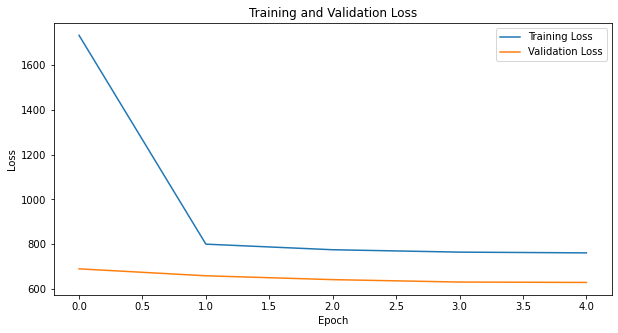

In [220]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [209]:
dev_loss, dev_accuracy_20, dev_accuracy_10 = model_3.evaluate(dev_x_list, dev_y)

print(dev_loss)
print(dev_accuracy_20)
print(dev_accuracy_10)






736/736 [==============================] - 1s 813us/step - loss: 659.5601 - Count_20: 0.6447 - Count_10: 0.3691
659.56005859375
0.644658625125885
0.369140625


In [210]:

print ("---------")
train_loss, train_accuracy_20, train_accuracy_10 = model_3.evaluate(train_x_list, train_y)
print(train_loss)
print(train_accuracy_20)

---------
7960/7960 [==============================] - 17s 2ms/step - loss: 764.2292 - Count_20: 0.5823 - Count_10: 0.3164
764.2291870117188
0.5822666883468628


In [211]:
for thres_overs in [0, 5, 10, 15, 19]:
    # Make a mask to get the relevant data
    mask = (dev_data_x['Over'] >= thres_overs).to_numpy()
    
    prediction_x = [x[mask] for x in dev_x_list]
    prediction_y = dev_y[mask]
    #print(prediction_x.shape)
    print(prediction_y.shape)
    
    ## Get the predictions
    prediction_loss, prediction_accuracy_20, prediction_accuracy_10 = model_3.evaluate(prediction_x, prediction_y)
    print(f"Over Range last {20 - thres_overs} overs --------------------------")
    print(f"Accuracy within 20 runs: {prediction_accuracy_20}    Accuracy Within 10 runs: {prediction_accuracy_10}")

(23552, 1)
736/736 [==============================] - 1s 801us/step - loss: 659.5601 - Count_20: 0.6447 - Count_10: 0.3691
Over Range last 20 overs --------------------------
Accuracy within 20 runs: 0.644658625125885    Accuracy Within 10 runs: 0.369140625
(17213, 1)
538/538 [==============================] - ETA: 0s - loss: 458.5368 - Count_20: 0.7067 - Count_10: 0.409 - 1s 2ms/step - loss: 483.1899 - Count_20: 0.7003 - Count_10: 0.4076
Over Range last 15 overs --------------------------
Accuracy within 20 runs: 0.7002846598625183    Accuracy Within 10 runs: 0.40759891271591187
(11041, 1)
346/346 [==============================] - 1s 2ms/step - loss: 328.5027 - Count_20: 0.7706 - Count_10: 0.4723
Over Range last 10 overs --------------------------
Accuracy within 20 runs: 0.770582377910614    Accuracy Within 10 runs: 0.47233039140701294
(5036, 1)
158/158 [==============================] - 0s 2ms/step - loss: 181.7666 - Count_20: 0.8882 - Count_10: 0.5907
Over Range last 5 overs -----